# Introduction

_The goal of this project is to create an iterative k-means clustering algorithm to cluster point guards based on their stats. We then use the sci-kit learn clustering method to compare ease and accuracy of the results._

In NBA media coverage, sports reporters usually focus on a handful of players and paint stories of how unique these players' stats are. We can use data science, particularly clustering, to explore that thread further.

Let's look at the dataset of player performance from the 2013-2014 season.

Here are some selected columns:

 - player: name of the player
 - pos: the position of the player
 - g: number of games the player was in
 - pts: total points the player scored
 - fg: field goal percentage
 - ft: free throw percentage

Database Basketball has an explanation of all the columns: http://www.databasebasketball.com/about/aboutstats.htm

## Exploring the dataset

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

nba = pd.read_csv("nba_2013.csv")
nba.head(3)

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013


Point guards play one of the most crucial roles on a team because their primary responsibility is to create scoring opportunities for the team. For point guards, it's widely accepted that the Assist to Turnover Ratio is a good indicator for performance in games as it quantifies the number of scoring opportunities that player created. Let's also use Points Per Game, since effective Point Guards not only set up scoring opportunities but also take a lot of the shots themselves.

Using 2 features allows us to easily visualize the players and will also make it easier to grasp how clustering works. 

In [12]:
point_guards = nba[nba['pos'] == 'PG']

In [13]:
#creating points per game column
point_guards['ppg'] = point_guards['pts'] / point_guards['g']

# Sanity check, make sure ppg = pts/g
print(point_guards[['pts', 'g', 'ppg']].head(5))

    pts   g        ppg
24  930  71  13.098592
29  150  20   7.500000
30  660  79   8.354430
38  666  72   9.250000
50  378  55   6.872727


/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Now let's create a column, atr, for the Assist Turnover Ratio, which is calculated by dividing total assists (ast) by total turnovers (tov).

We drop the players who have 0 turnovers. Not only did these players only play a few games, making it hard to understand their true abilities, but we also cannot divide by 0 when we calculate atr.

In [14]:
point_guards = point_guards[point_guards['tov'] != 0]
point_guards['atr'] = point_guards['ast'] / point_guards['tov']

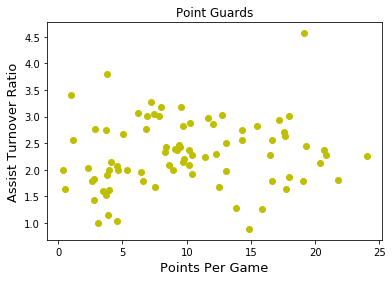

In [15]:
plt.scatter(point_guards['ppg'], point_guards['atr'], c='y')
plt.title("Point Guards")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)
plt.show()

## Clustering

There seem to be 5 general regions, or clusters, that the point guards fall into. We use unsupervised machine learning, like clustering, techniques to explore the structure within a data set that doesn't have a clear value to optimize.

There are multiple clustering methods, but we will use centroid-based clustering. Centroid based clustering works well when the clusters resemble circles with centers (or centroids). The centroid represent the arithmetic mean of all of the data points in that cluster.

### K-Means Clustering

K-Means clustering is an iterative algorithm that switches between recalculating the centroid of each cluster and the players that belong to that cluster. To start, select 5 players at random and assign their coordinates as the initial centroids of the just created clusters.

**Step 1 (Assign Points to Clusters):** For each player, calculate the Euclidean distance between that player's coordinates, or values for atr & ppg, and each of the centroids' coordinates. Assign the player to the cluster whose centroid is the closest to, or has the lowest Euclidean distance to, the player's values.

**Step 2 (Update New Centroids of the Clusters):** For each cluster, compute the new centroid by calculating the arithmetic mean of all of the points (players) in that cluster. We calculate the arithmetic mean by taking the average of all of the X values (atr) and the average of all of the Y values (ppg) of the points in that cluster.

Iterate Repeat steps 1 & 2 until the clusters are no longer moving and have converged.

In [16]:
num_clusters = 5
# Use numpy's random function to generate a list, length: num_clusters, of indices
random_initial_points = np.random.choice(point_guards.index, size=num_clusters)
# Use the random indices to create the centroids
centroids = point_guards.loc[random_initial_points]

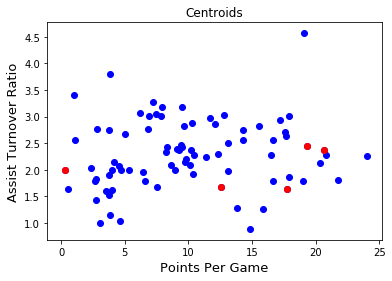

In [19]:
#Let's plot the centroids, in addition to the point_guards, 
#so we can see where the randomly chosen centroids started out.
plt.scatter(point_guards['ppg'], point_guards['atr'], c='blue')
plt.scatter(centroids['ppg'], centroids['atr'], c='red')
plt.title("Centroids")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)
plt.show()

### Setup

In [20]:
#use a dictionary object to represent the centroids
def centroids_to_dict(centroids):
    dictionary = dict()
    # iterating counter we use to generate a cluster_id
    counter = 0

    # iterate a pandas data frame row-wise using .iterrows()
    for index, row in centroids.iterrows():
        coordinates = [row['ppg'], row['atr']]
        dictionary[counter] = coordinates
        counter += 1

    return dictionary

centroids_dict = centroids_to_dict(centroids)

### Step 1: Assign points to clusters

In [21]:
#compare the ppg and atr values of the players 
#with each cluster's centroids via euclidean dsitance
import math

def calculate_distance(centroid, player_values):
    root_distance = 0
    
    for x in range(0, len(centroid)):
        difference = centroid[x] - player_values[x]
        squared_difference = difference**2
        root_distance += squared_difference

    euclid_distance = math.sqrt(root_distance)
    return euclid_distance

Now we need a way to assign data points to clusters based on Euclidean distance. Instead of creating a new variable or data structure to house the clusters, let's keep things simple and just add a column to the point_guards data frame that contains the cluster_id of the cluster it belongs to.

In [23]:
#For each player, we want to calculate the distances to each cluster's centroid using euclidean_distance.
#Once we know the distances, we can determine which centroid is the closest and return that centroid's cluster_id.
def assign_to_cluster(row):
    lowest_distance = -1
    closest_cluster = -1
    
    for cluster_id, centroid in centroids_dict.items():
        df_row = [row['ppg'], row['atr']]
        euclidean_distance = calculate_distance(centroid, df_row)
        
        if lowest_distance == -1:
            lowest_distance = euclidean_distance
            closest_cluster = cluster_id 
        elif euclidean_distance < lowest_distance:
            lowest_distance = euclidean_distance
            closest_cluster = cluster_id
    return closest_cluster

#Create a new column, cluster, that contains the row-wise results of assign_to_cluster.
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)

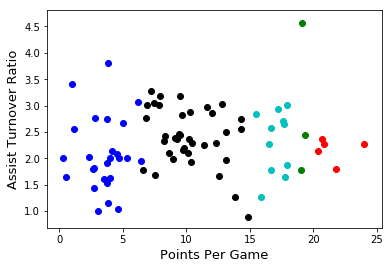

In [24]:
# Visualizing clusters
def visualize_clusters(df, num_clusters):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        plt.scatter(clustered_df['ppg'], clustered_df['atr'], c=colors[n-1])
        plt.xlabel('Points Per Game', fontsize=13)
        plt.ylabel('Assist Turnover Ratio', fontsize=13)
    plt.show()

visualize_clusters(point_guards, 5)

### Step 2: Update New Centroids of the Clusters

In [25]:
def recalculate_centroids(df):
    new_centroids_dict = dict()
    
    for cluster_id in range(0, num_clusters):
        values_in_cluster = df[df['cluster'] == cluster_id]
        # Calculate new centroid using mean of values in the cluster
        new_centroid = [np.average(values_in_cluster['ppg']), np.average(values_in_cluster['atr'])]
        new_centroids_dict[cluster_id] = new_centroid
    return new_centroids_dict

centroids_dict = recalculate_centroids(point_guards)

### Iterate
We now repeat step 1 and see how the clusters have changed

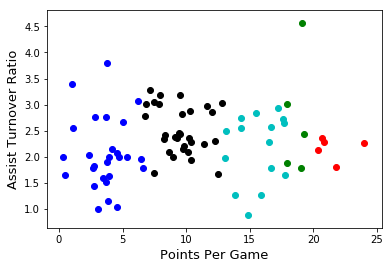

In [28]:
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)

Now, we recalculate the centroids and shift the clusters again

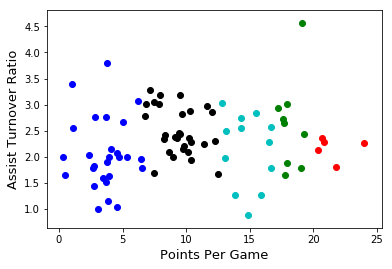

In [29]:
centroids_dict = recalculate_centroids(point_guards)
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)

### Observations
As we repeat Steps 1 and 2 and run visualize_clusters, notice that a few of the points are changing clusters between every iteration (especially in areas where 2 clusters almost overlap), but otherwise, the clusters visually look like they don't move a lot after every iteration. This means 2 things:

 - K-Means doesn't cause massive changes in the makeup of clusters between iterations, meaning that it will always converge and become stable
 - Because K-Means is conservative between iterations, where we pick the initial centroids and how we assign the players to clusters initially matters a lot

### Sci-kit Learn Implementation

To counteract these problems, the sklearn implementation of K-Means does some intelligent things like re-running the entire clustering process lots of times with random initial centroids so the final results are a little less biased on one passthrough's initial centroids.

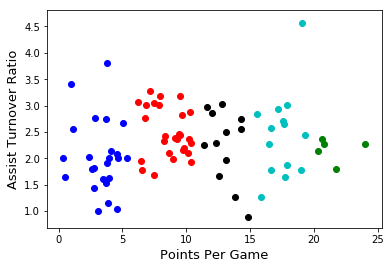

In [30]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(point_guards[['ppg', 'atr']])
point_guards['cluster'] = kmeans.labels_

visualize_clusters(point_guards, num_clusters)